In [1]:
#Imports
import os
from random import uniform
import subprocess
from pathlib import Path
from nufeb_tools import utils,plot
import pandas as pd
from string import Template
import numpy as np
from functools import partial
import time
from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
from skopt.plots import plot_convergence, plot_objective
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score

In [2]:
test_data = pd.read_excel('../experimental-data/sucrose-OD-IPTG-sweep.xls',sheet_name='data')
from scipy.optimize import curve_fit
def od_func(x):
    """Exponential fit to IPTG vs OD750 experimental data

    Args:
        x (float): IPTG concentration (mM)

    Returns:
        float: Smoothed OD750
    """
    return 0.25482 * np.exp(-x/.06811) + 1.12893
def suc_func(x,a,b,c):
    return a*np.exp(-x/b)+c
# Smooth OD750 data for fitting
test_data.loc[:,'OD750'] = od_func(test_data.IPTG)
#popt, pcov = curve_fit(suc_func, test_data.IPTG, test_data.Sucrose)
    #Compare output with experimental data
#OD = interpolate.interp1d(test_data.IPTG,test_data.OD750)
#Sucrose = interpolate.interp1d(test_data.IPTG,test_data.Sucrose)
#sim = interpolate.interp1d(df.Hours.to_numpy(),df.OD600.to_numpy())
#x_range = np.arange(0,1,.01)
#plt.plot(x_range,suc_func(x_range))
#plt.plot(test_data.IPTG,test_data.Sucrose,marker='o')
#plt.plot(x_range, suc_func(x_range, *popt), 'r-')
#xr = np.array([0.001,.01,.05,0.2,1])
#plt.plot(xr,suc_func(xr, *popt),marker='s',ls='')
#plt.plot(x_range,od_func(x_range))
#residual = abs(r2_score(exp(x_range),sim(x_range))-1)

In [3]:
t2 = test_data.copy()
t2.loc[2,'OD750']=1.40
t2.loc[4,'OD750']=1.23
t2.sort_values(by='IPTG',inplace=True)
print(t2)
abs(r2_score(t2[['OD750','Sucrose']],test_data[['OD750','Sucrose']])-1)

    IPTG     OD750   Sucrose
0  0.000  1.383750  0.107117
1  0.005  1.365714  0.200273
2  0.010  1.400000  0.584090
3  0.020  1.318909  1.473699
4  0.050  1.230000  2.405350
5  0.100  1.187624  2.790814
6  0.200  1.142449  3.234595
7  0.500  1.129095  3.348596
8  1.000  1.128930  3.230569


0.014762782427352406

In [4]:
# Base install of NUFEB
os.chdir('/tmp')
os.system('git clone https://github.com/Jsakkos/NUFEB --recursive')
os.chdir('NUFEB')
os.system('git checkout cyano')
initial_compile = subprocess.run('/home/12x/init-compile.sh')


In [5]:
#nufeb_compile = subprocess.run('/home/12x/rapid-compile.sh')


In [6]:
def recompile(alpha,tau,c,alpha2,tau2,c2):
    os.chdir('/tmp/NUFEB')
    filein = open( f'/home/12x/nufeb-cyano-e-coli/templates/fix_bio_kinetics_monod2.txt' )
    #read it
    src = Template( filein.read() )
    #do the substitution
    result = src.safe_substitute({'alpha' : alpha, 'tau' : tau, 'c' : c,'alpha2' : alpha2, 'tau2' : tau2, 'c2' : c2
                                        
                                        })
    with open("/tmp/NUFEB/src/USER-NUFEB/fix_bio_kinetics_monod.cpp","w") as f:
       f.writelines(result)
    #Compile NUFEB
    nufeb_compile = subprocess.run('/home/12x/rapid-compile.sh')

In [7]:
def test_run():
    os.chdir('/tmp/NUFEB')
    os.system('nufeb-clean')
    text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700'
    os.system(text)
    run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)

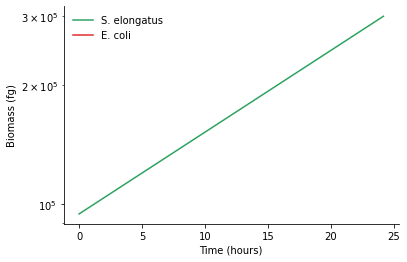

In [8]:
# Test to make sure everything is working
recompile(1,.03,.01,1,.05,.25)
test_run()
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]
data = [utils.get_data(directory=str(x)) for x in folders]
f, ax = plt.subplots()
plot.overall_growth(data[0].biomass,ax=ax)
plt.show()

In [9]:
from tqdm.notebook import tqdm

class tqdm_skopt(object):
    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)
        
    def __call__(self, res):
        self._bar.update()

In [10]:
def func(x):

    alpha = x[0]
    tau = x[1]
    c = x[2]
    alpha2 = x[3]
    tau2 = x[4]
    c2 = x[5]
    mu = x[6]
    rho = x[7]




    #Change input params
    
    os.chdir('/tmp/NUFEB')
    recompile(alpha,tau,c,alpha2,tau2,c2)

    #Clean old simulations
    os.system('nufeb-clean')
    #Run simulation
    for iptg in test_data.IPTG:
        text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {mu} --sucR {iptg} --rhocya {rho}'
        os.system(text)

    run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)
    BASE_DIR = Path(f'runs/')
    folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

    #Extract output

    data = [utils.get_data(directory=str(x)) for x in folders]
    Volume = 1e-4*1e-4*1e-4 #m^3
    CellNum2OD = Volume*1e6/0.3e-8
    SucroseMW = 342.3
    dfs = []
    for x in data:
        temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
        temp.columns=['OD750','Hours','Sucrose']
        temp['IPTG'] = x.metadata['SucRatio']
        dfs.append(temp)
    df = pd.concat(dfs,ignore_index=True)
    df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
    df.sort_values(by='IPTG',inplace=True)
    df.reset_index(inplace=True)
    #Compare output with experimental data via RMSE

    return ((df[['OD750','Sucrose']]-test_data[['OD750','Sucrose']]) ** 2).mean().mean() ** .5

    #Optimize
""" def optimize():
    

    res = gp_minimize(func,                  # the function to minimize
                    ,      # the bounds on each dimension of x
                    acq_func="EI",      # the acquisition function
                    n_calls=5,         # the number of evaluations of f
                    n_random_starts=5,  # the number of random initialization points
                    random_state=1234)
    print(res)
    file_pi = open('results.obj', 'w') 
    pickle.dump(res, file_pi) """

' def optimize():\n    \n\n    res = gp_minimize(func,                  # the function to minimize\n                    ,      # the bounds on each dimension of x\n                    acq_func="EI",      # the acquisition function\n                    n_calls=5,         # the number of evaluations of f\n                    n_random_starts=5,  # the number of random initialization points\n                    random_state=1234)\n    print(res)\n    file_pi = open(\'results.obj\', \'w\') \n    pickle.dump(res, file_pi) '

In [11]:

alpha_min = float('0')
alpha_max = float('5e-1')
tau_min = float('0')
tau_max = float('1e-1')
c_min = float('0')
c_max = float('5e-1')
alpha2_min = float('0')
alpha2_max = float('5e1')
tau2_min = float('0')
tau2_max = float('1e-1')
c2_min = float('0')
c2_max = float('5e1')

mu_min = float('1e-6')
mu_max = float('5e-5')
rho_min = 320
rho_max = 390
bounds = [(alpha_min,alpha_max),(tau_min,tau_max),(c_min,c_max),(alpha2_min,alpha2_max),(tau2_min,tau2_max),(c2_min,c2_max),(mu_min,mu_max),(rho_min,rho_max)]




n_calls = 60
#et_res = forest_minimize(func, bounds, n_calls=n_calls,callback=[tqdm_skopt(total=n_calls, desc="Random forest")],base_estimator="ET",n_initial_points =20)
gp_res = gp_minimize(func, bounds, n_calls=n_calls,n_initial_points=20,random_state=5348,verbose=True,callback=[tqdm_skopt(total=n_calls, desc="Bayesian opt")])

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 246.7982
Function value obtained: 0.9079
Current minimum: 0.9079
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 215.3235
Function value obtained: 1.0101
Current minimum: 0.9079
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 263.6978
Function value obtained: 0.9399
Current minimum: 0.9079
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 174.1084
Function value obtained: 1.5213
Current minimum: 0.9079
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 226.0310
Function value obtained: 1.3398
Current minimum: 0.9079
Iteration No: 6 started. 

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

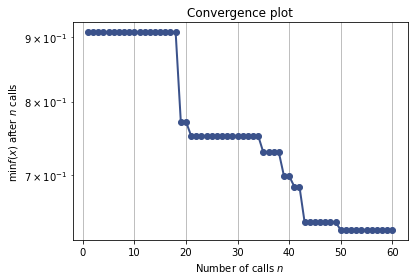

In [12]:
plot_convergence(gp_res,yscale='log')

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{2}$'>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{3}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{3}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{4}$'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>,
        <AxesSubplot:xlabel='$X_{4}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<A

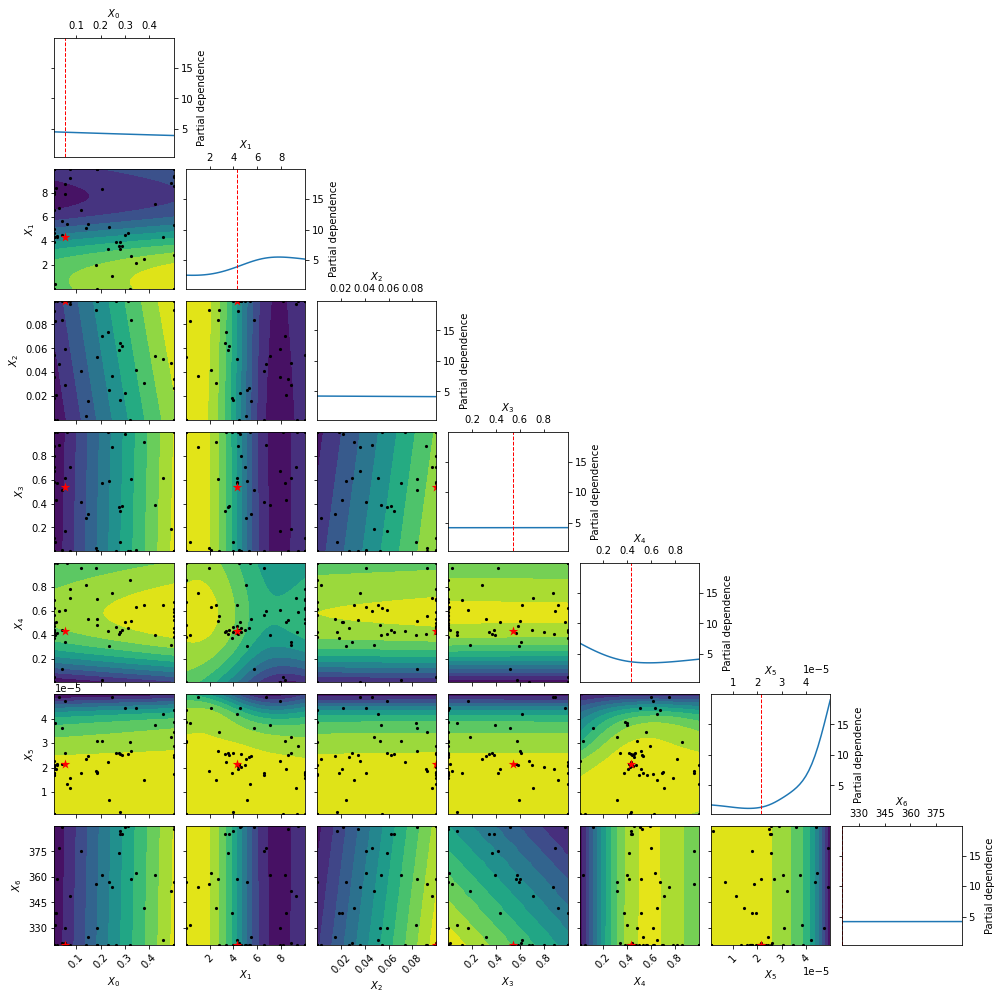

In [13]:
plot_objective(gp_res)

In [14]:
gp_res.x

[0.05230549727455282,
 4.308608118584795,
 0.1,
 0.5421369492026907,
 0.4338509485483162,
 2.156617120244333e-05,
 320]

In [15]:
os.chdir('/tmp/NUFEB')
recompile(gp_res.x[0],gp_res.x[1],gp_res.x[2],gp_res.x[3],gp_res.x[4])

#Clean old simulations
os.system('nufeb-clean')
#Run simulation
for iptg in test_data.IPTG:
    text = f'nufeb-seed --cells 100,0 --d 1e-4,1e-4,1e-4 --grid 20 --t 8700 --mucya {gp_res.x[5]} --sucR {iptg} --rhocya {gp_res.x[6]}'
    os.system(text)

run_nufeb = subprocess.run('/home/12x/optim2.sh', stdout=subprocess.DEVNULL)
BASE_DIR = Path(f'runs/')
folders = [path for path in BASE_DIR.iterdir() if path.is_dir()]

#Extract output

data = [utils.get_data(directory=str(x)) for x in folders]
Volume = 1e-4*1e-4*1e-4 #m^3
CellNum2OD = Volume*1e6/0.3e-8
SucroseMW = 342.3
dfs = []
for x in data:
    temp = pd.concat([x.ntypes.cyano/CellNum2OD,x.ntypes.step/60/60*x.timestep,x.avg_con.Sucrose.reset_index(drop=True)],axis=1)
    temp.columns=['OD750','Hours','Sucrose']
    temp['IPTG'] = x.metadata['SucRatio']
    dfs.append(temp)
df = pd.concat(dfs,ignore_index=True)
df = df.loc[(df.Hours > 23.8) & (df.Hours < 24)]
df.sort_values(by='IPTG',inplace=True)
df.reset_index(inplace=True)

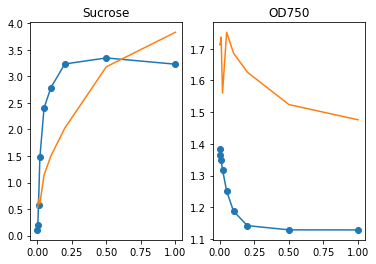

In [16]:
f, ax = plt.subplots(ncols=2)
ax[0].set_title('Sucrose')
ax[0].plot(test_data.IPTG,test_data.Sucrose,marker='o')
ax[0].plot(df.IPTG,df.Sucrose)
ax[1].set_title('OD750')
ax[1].plot(test_data.IPTG,test_data.OD750,marker='o')
ax[1].plot(df.IPTG,df.OD750)

In [17]:
((df[['OD750','Sucrose']]-test_data[['OD750','Sucrose']]) ** 2).mean() ** .5


OD750      0.401567
Sucrose    0.827631
dtype: float64

In [18]:
df

,index,OD750,Hours,Sucrose,IPTG
0,790,1.713,23.888889,0.527416,0.000
1,702,1.719,23.888889,0.533876,0.005
2,614,1.737,23.888889,0.686011,0.010
3,526,1.560,23.888889,0.602892,0.020
4,438,1.752,23.888889,1.141209,0.050
5,350,1.686,23.888889,1.503434,0.100
6,262,1.626,23.888889,2.025391,0.200
7,174,1.524,23.888889,3.181522,0.500
8,86,1.476,23.888889,3.832755,1.000
